<a href="https://colab.research.google.com/github/talhaanwarch/mia-covid19/blob/main/lightnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2c0baa89-844b-b035-d21e-1df351ee943d)


In [1]:
#connect drive with colab notebook/
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/covid/train.zip /content/
!cp /content/drive/MyDrive/covid/val.zip /content/

In [3]:
%%capture 
!unzip /content/train.zip
!rm /content/train.zip
!mv /content/resized /content/train


In [4]:
%%capture 
!unzip /content/val.zip -d val
!rm /content/val.zip


In [1]:
import pandas as pd
import numpy as np
from glob import glob
import cv2


In [2]:
# #load data, data loaded is in format of list of list containing folder and image paths
# train_pos_path=[glob(folder+'*.jpg') for folder in glob('train/covid/*/')]
# train_neg_path=[glob(folder+'*.jpg') for folder in glob('train/non-covid/*/')]
# len(train_pos_path),len(train_neg_path)

In [3]:
# #create labels for list of list images
# train_pos_label=[[0]*len(i)  for i in train_pos_path]
# train_neg_label=[[1]*len(i)  for i in train_neg_path]
# len(train_pos_label),len(train_neg_label)

In [4]:
# #combine data
# train_path=train_pos_path+train_neg_path
# train_label=train_pos_label+train_neg_label
# len(train_path),len(train_label)

In [5]:
# #plit data 
# from sklearn.model_selection import train_test_split
# train_path,val_path,train_label,val_label=train_test_split(train_path,train_label,test_size=0.2)

In [6]:
# #flatten list
# train_path = [item for sublist in train_path for item in sublist]
# val_path = [item for sublist in val_path for item in sublist]
# train_label = [item for sublist in train_label for item in sublist]
# val_label = [item for sublist in val_label for item in sublist]
# len(train_path),len(train_label),len(val_path),len(val_label)

In [7]:
# train_df=pd.DataFrame(zip(train_path,train_label),columns=['img','label'])
# train_df = train_df.sample(frac=1).reset_index(drop=True)
# train_df.to_csv('train_df.csv',index=False)
# train_df.head()

In [8]:
# val_df=pd.DataFrame(zip(val_path,val_label),columns=['img','label'])
# val_df = val_df.sample(frac=1).reset_index(drop=True)
# val_df.to_csv('val_df.csv',index=False)
# val_df.head()

In [9]:
# #calculate mean and standard deviation of random images
# mean,std=[],[]
# for i in train_df.img[0:100]:
#     img=cv2.imread(i,0)/255.0
#     mean.append(np.mean(img)),std.append(np.std(img))
    
# print('mean',np.mean(mean))
# print('std',np.mean(std))

In [10]:
train_df=pd.read_csv('/content/drive/MyDrive/covid/train_df.csv')
val_df=pd.read_csv('/content/drive/MyDrive/covid/val_df.csv')
train_df.head()

,image,label
0,/content/train/non-covid/ct_scan_307/376.jpg,0
1,/content/train/covid/ct_scan_206/2.jpg,1
2,/content/train/covid/ct_scan_95/266.jpg,1
3,/content/train/covid/ct_scan_579/4.jpg,1
4,/content/train/covid/ct_scan_185/7.jpg,1


In [11]:
import torch 
from torchvision import transforms 
import torchvision.models as models
import torch.nn as nn

In [12]:
aug=transforms.Compose([
                        #transforms.Resize((224,224)),
                        #transforms.Grayscale(),
                        transforms.CenterCrop(224),
                        transforms.RandomHorizontalFlip(p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomRotation(degrees=3),
                        transforms.RandomPerspective(0.05,0.2),
                        transforms.ToTensor(),
                        transforms.Normalize([0.5, ], [0.5,]),

                        ])

In [13]:
from PIL import Image
class dfloader(torch.utils.data.Dataset):
    
    def __init__(self,img_id,img_label,transform=None):
        self.img_id = img_id    
        self.img_label=img_label
        self.transform=transform
        
    def __getitem__(self,index):
        if type(index) == torch.Tensor:
          index = index.item()
        img_ind=self.img_id[index]
        label_ind=self.img_label[index]

        img = Image.open(img_ind).convert('L')
      
        if self.transform:
           img=self.transform(img) 
  
        return img ,label_ind
    
    def __len__(self):
        return len(self.img_id)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


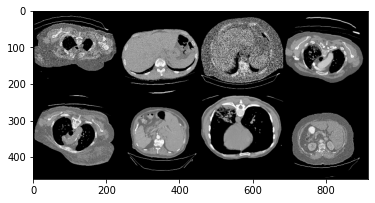

In [14]:
from torch.utils.data.dataloader import DataLoader
import torchvision
import matplotlib.pyplot as plt
train=dfloader(train_df.image.values,train_df.label.values,transform=aug)
train_loader = DataLoader(train,shuffle=True,num_workers=0,batch_size=8)
batch,_=next(iter(train_loader))
grid_img=torchvision.utils.make_grid(batch,4,4)
plt.imshow(grid_img.permute(1, 2, 0),cmap='gray')

In [15]:
import torch
import torch.nn as nn
class Fire1(nn.Module):
   
    def __init__(self, in_channels, squeeze_channels,expand_channels):
        super(Fire1, self).__init__()

        # squeeze 
        self.squeeze = nn.Conv2d(in_channels, squeeze_channels, kernel_size=1)
        self.relu = nn.LeakyReLU()

        # expand
        self.expand_1x1 =nn.Conv2d(squeeze_channels, expand_channels, kernel_size=1)
        self.expand_3x3 =nn.Conv2d(squeeze_channels, expand_channels, kernel_size=3,padding=1)
        

    def forward(self, x):
        x = self.squeeze(x)
        x= self.relu(x)
        x = torch.cat([self.expand_1x1(x),self.expand_3x3(x)], dim=1)
        x = self.relu(x)
        return x
    
    
class MyModelV3(torch.nn.Module):
    
    def __init__(self):
        super(MyModelV3, self).__init__()
        self.net = torch.nn.Sequential(
                 nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,stride=2),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 nn.ReLU(),
                 nn.BatchNorm2d(32),
                 Fire1(in_channels=32, squeeze_channels=16,expand_channels=32),
                 Fire1(in_channels=64, squeeze_channels=16,expand_channels=64),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 nn.Dropout(0.5),
                 #nn.BatchNorm2d(128),
                 Fire1(in_channels=128, squeeze_channels=32,expand_channels=96),
                 Fire1(in_channels=192, squeeze_channels=32,expand_channels=128),
                 nn.MaxPool2d(kernel_size=3,stride=2),
                 nn.Dropout(0.25),
                 #nn.BatchNorm2d(256),
                 Fire1(256, 48, 160),
                 Fire1(320, 48, 160),
                 nn.Dropout(0.5),
                 #nn.BatchNorm2d(320),
                 nn.Conv2d(in_channels=320,out_channels=128*2,kernel_size=1,stride=2),
                 nn.LeakyReLU(),
                 nn.Conv2d(in_channels=128*2,out_channels=32,kernel_size=1,stride=1),
                 nn.ReLU(),
                 nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,stride=1),
                 nn.ReLU(),
                 nn.Dropout(0.5),
                 #nn.Conv2d(in_channels=32,out_channels=16,kernel_size=1,stride=1),
                 nn.Flatten(),
                 #PrintShape(),
                 nn.Linear(784, 1),
                 # nn.Linear(512*2, 512)
                
               
                )        
    def forward(self, x):
        return self.net(x)    

In [16]:
from sklearn.metrics import classification_report,f1_score
from time import time

def get_accuracy(y_true, y_pred):
    assert y_true.ndim == 1 and y_true.size() == y_pred.size()
    y_pred = y_pred > 0.5
    return (y_true == y_pred).sum().item() / y_true.size(0)

def fit_train(loader):
    loss_sum=0
    acc_sum=0
    scaler = torch.cuda.amp.GradScaler() 
    for batch in loader:
        img,label=batch
        with torch.cuda.amp.autocast(): 
          img,label = img.to(device),label.to(device)
          out=model(img)
          loss=criterion(out.view(-1),label.float())
        opt.zero_grad()
        scaler.scale(loss).backward()
        #loss.backward()
        scaler.step(opt)
        #opt.step()
        scaler.update()
        loss_sum+=loss.item()
        acc_sum += get_accuracy(label,out.view(-1))
    return loss_sum,acc_sum
def fit_val(loader):
    loss_sum=0
    acc_sum=0
    for batch in loader:
        img,label=batch
        img,label = img.to(device),label.to(device)
        out=model(img)
        loss=criterion(out.view(-1),label.float())
        loss_sum+=loss.item()
        acc_sum += get_accuracy(label,out.view(-1))
    return loss_sum,acc_sum

def fit_test(loader):
  test_pred=[]
  for img,_ in loader:
    test_pred.append(model(img.to(device)))
  test_pred=torch.cat(test_pred,dim=0)
  y_pred=test_pred.cpu().numpy()
  return y_pred


def fit(model,train_loader,val_loader,test_loader=None,epoch=10,scheduler_step=None,verbose=None):
  
  train_loss_plt=[]
  val_loss_plt=[]
  train_acc_plt=[]
  val_acc_plt=[]
  for ep in range(epoch):
    start=time()
    #start training loop
    train_loss,train_acc=fit_train(train_loader)
    #start validation loop
    model.eval()
    with torch.no_grad():
        val_loss,val_acc=fit_val(val_loader)
    end=np.round((time()-start)/60,2) #time in minute
    model.train()

    #calculate print and append the results for plotting purpose
    val_avg_loss=np.round(val_loss/len(val_loader),2)#val loss of all batches of one epoch
    train_avg_loss=np.round(train_loss/len(train_loader),2)# train loss of all batches of one epoch
    train_avg_acc=np.round(train_acc/len(train_loader),2)#train acc of all batches of one epoch
    val_avg_acc=np.round(val_acc/len(val_loader),2)#val acc of all batches of one epoch
    if scheduler_step:
      scheduler.step(val_avg_loss)
    if verbose:
      print('Epoch {}, time {} min , train acc  {}, train loss {} , val acc is {}, loss is {}, learning rate is {} '.format
            (ep,end,train_avg_acc,train_avg_loss,val_avg_acc,val_avg_loss,opt.param_groups[0]['lr']))
    train_loss_plt.append(train_avg_loss)  #append loss of training data  
    val_loss_plt.append(val_avg_loss)     #append loss of validation data
    train_acc_plt.append(train_avg_acc)  #append acc of training data  
    val_acc_plt.append(val_avg_acc)     #append acc of validation data
 
 #test phase
  if test_loader:
      model.eval()
      with torch.no_grad():
         y_pred=fit_test(test_loader)
  
  return [train_loss_plt,val_loss_plt,train_acc_plt,val_acc_plt]

In [17]:
from torch.utils.data.dataloader import DataLoader
train=dfloader(train_df.image.values,train_df.label.values,transform=aug)
val=dfloader(val_df.image.values,val_df.label.values,transform=aug)
train_loader = DataLoader(train,shuffle=True,num_workers=0,batch_size=786)
val_loader = DataLoader(val,shuffle=True,num_workers=0,batch_size=786)

In [18]:
device=torch.device('cuda')
model=MyModelV3().to(device)
criterion = nn.BCEWithLogitsLoss()
opt=torch.optim.AdamW(params=model.parameters(),lr=0.001)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=2)

In [19]:
res=fit(model,train_loader,val_loader,epoch=8,scheduler_step=True,verbose=True)

Epoch 0, time 17.23 min , train acc  0.62, train loss 0.62 , val acc is 0.66, loss is 0.63, learning rate is 0.001 
Epoch 1, time 17.18 min , train acc  0.74, train loss 0.5 , val acc is 0.7, loss is 0.62, learning rate is 0.001 
Epoch 2, time 17.05 min , train acc  0.8, train loss 0.42 , val acc is 0.7, loss is 0.64, learning rate is 0.001 
Epoch 3, time 16.92 min , train acc  0.84, train loss 0.34 , val acc is 0.73, loss is 0.69, learning rate is 0.001 
Epoch 4, time 17.1 min , train acc  0.87, train loss 0.29 , val acc is 0.74, loss is 0.73, learning rate is 0.0001 
Epoch 5, time 16.91 min , train acc  0.9, train loss 0.22 , val acc is 0.75, loss is 0.74, learning rate is 0.0001 
Epoch 6, time 16.88 min , train acc  0.91, train loss 0.21 , val acc is 0.75, loss is 0.73, learning rate is 0.0001 
Epoch 7, time 16.9 min , train acc  0.91, train loss 0.2 , val acc is 0.75, loss is 0.75, learning rate is 1e-05 


In [ ]:
state = {
        'epoch': 15,
        'state_dict': model.state_dict(),
        'optimizer': opt.state_dict(),
}
savepath=/content/drive/MyDrive/covid/+'0to15.pt'
torch.save(state,savepath)